In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
from keras import layers
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import metrics
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from sklearn.metrics import f1_score

Image Preprocessing

In [2]:
# Set the path to your dataset
BASE_PATH = "C:\\DL Testing Set"

# Step 1: Image Preprocessing
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


            labels  encoded_labels
0          Araneae               0
4776    Coleoptera               1
5315       Diptera               2
5892     Hemiptera               3
6580   Hymenoptera               4
7251   Lepidoptera               5
10649      Odonata               6


In [4]:
def img_display(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg


In [4]:
class InsectDataset(Dataset):
    def __init__(self, img_data, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        self.filenames = []  # Store filenames

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        img_name = os.path.join(self.img_path, self.img_data.loc[index, 'labels'], self.img_data.loc[index, 'Images'])
        self.filenames.append(img_name)  # Store filename
        image = Image.open(img_name)
        image = image.resize((224, 224))  # Resize images
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)  # Apply transformation here
        return image, label



Training the Insect Classification Model

In [5]:
# Step 3: Training the Models
# Split the data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Number of classes (insects)
num_classes = len(unique_labels)


# Define batch size
batch_size = 64   # You can adjust this based on your system's capacity

# Assuming you have train_gen and test_gen already defined as ImageDataGenerator instances
train_gen = ImageDataGenerator(rescale=(1./255.),
    validation_split=0.2,
    rotation_range=20,  # Example: Rotate images by 20 degrees
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=(1./255.))

In [6]:
# Step 2: Model Modification for Insect Classification
def get_alexnet_model(num_classes):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [7]:
# Create the model
alexnet_model = get_alexnet_model(num_classes)

In [8]:
from keras.models import load_model

# Compile the model
alexnet_model.compile(loss="categorical_crossentropy",
                      optimizer=SGD(learning_rate=0.001, momentum=0.9),
                      metrics=['accuracy', metrics.Recall(), metrics.Precision(), metrics.AUC()])

# Assuming you have train_dir and val_dir already defined
train_dir = BASE_PATH
val_dir = BASE_PATH

# Train AlexNet
history_alexnet = alexnet_model.fit(
    train_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, 
                                  class_mode='categorical', subset='training'),
    epochs=10,
    validation_data=train_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, 
                                                  class_mode='categorical', subset='validation'),
    callbacks=[EarlyStopping(patience=3)]
)


# Save the model
alexnet_model.save("C:/Deep Learning/Project/Classification Models/alexnet_modelv3.h5")

# Save training history to a CSV file
history_df = pd.DataFrame(history_alexnet.history)
history_df.to_csv("C:/Deep Learning/Project/Classification Models/alexnet_historyv3.csv", index=False)



Found 11628 images belonging to 7 classes.
Found 2902 images belonging to 7 classes.
Epoch 1/10
182/182 [==============================] - 7001s 38s/step - loss: 1.0586 - accuracy: 0.6477 - recall_1: 0.5359 - precision_1: 0.7731 - auc_1: 0.9035 - val_loss: 0.8814 - val_accuracy: 0.6899 - val_recall_1: 0.6085 - val_precision_1: 0.7909 - val_auc_1: 0.9342
Epoch 2/10
182/182 [==============================] - 5210s 29s/step - loss: 0.7930 - accuracy: 0.7322 - recall_1: 0.6421 - precision_1: 0.8341 - auc_1: 0.9455 - val_loss: 0.8523 - val_accuracy: 0.7095 - val_recall_1: 0.6330 - val_precision_1: 0.7946 - val_auc_1: 0.9391
Epoch 3/10
182/182 [==============================] - 4818s 26s/step - loss: 0.7429 - accuracy: 0.7466 - recall_1: 0.6657 - precision_1: 0.8358 - auc_1: 0.9525 - val_loss: 0.8582 - val_accuracy: 0.7012 - val_recall_1: 0.6099 - val_precision_1: 0.7977 - val_auc_1: 0.9377
Epoch 4/10
182/182 [==============================] - 4049s 22s/step - loss: 0.7098 - accuracy: 0.7641

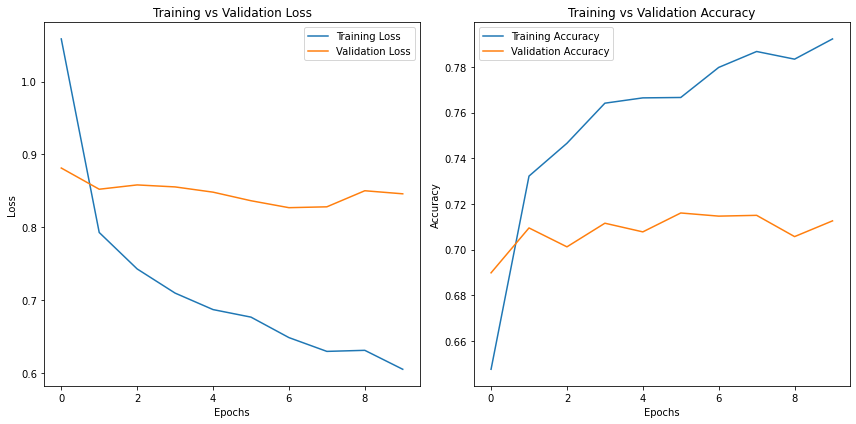

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = "C:/Deep Learning/Project/Classification Models/alexnet_historyv3.csv"  # Update with the correct file path
history_data = pd.read_csv(file_path)

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Testing Prediction on Unlabeled Images

1/1 [==============================] - 1s 1s/step


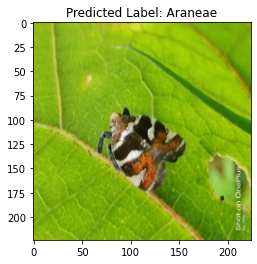

Predicted Label for the New Image: Araneae


In [8]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv3.h5")


# Specify the path to the new, unlabeled image
new_image_path = "C:/Unlabeled Images/IMG_20211017_080648.jpg"

# Load and preprocess the new image
new_image = Image.open(new_image_path)
new_image = new_image.resize((224, 224))
new_image_array = np.array(new_image) / 255.0  # Normalize pixel values
new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension

# Make predictions on the new image
new_image_prediction = loaded_model.predict(new_image_array)

# Convert the prediction to a class label
predicted_label = lb.inverse_transform(new_image_prediction.argmax(axis=1))[0]

# Display the new image along with the predicted label
plt.imshow(new_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

print("Predicted Label for the New Image:", predicted_label)


1/1 [==============================] - 2s 2s/step


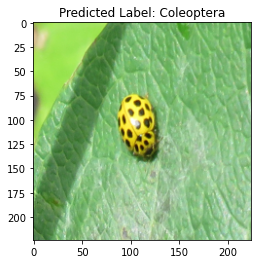

Predicted Label for the New Image: Coleoptera


In [13]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv3.h5")



# Specify the path to the new, unlabeled image
new_image_path = "C:/kaggle/input/ArTaxOr/Coleoptera/0bd077deb271.jpg"

# Load and preprocess the new image
new_image = Image.open(new_image_path)
new_image = new_image.resize((224, 224))
new_image_array = np.array(new_image) / 255.0  # Normalize pixel values
new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension

# Make predictions on the new image
new_image_prediction = loaded_model.predict(new_image_array)

# Convert the prediction to a class label
predicted_label = lb.inverse_transform(new_image_prediction.argmax(axis=1))[0]

# Display the new image along with the predicted label
plt.imshow(new_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

print("Predicted Label for the New Image:", predicted_label)


1/1 [==============================] - 2s 2s/step


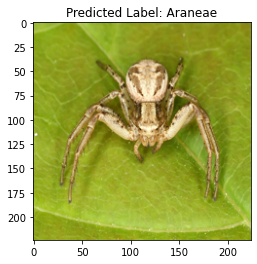

Predicted Label for the New Image: Araneae


In [14]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv3.h5")

# Specify the path to the new, unlabeled image
new_image_path = "C:/kaggle/input/ArTaxOr/Araneae/fa6b4011c1f0.jpg"

# Load and preprocess the new image
new_image = Image.open(new_image_path)
new_image = new_image.resize((224, 224))
new_image_array = np.array(new_image) / 255.0  # Normalize pixel values
new_image_array = np.expand_dims(new_image_array, axis=0)  # Add batch dimension

# Make predictions on the new image
new_image_prediction = loaded_model.predict(new_image_array)

# Convert the prediction to a class label
predicted_label = lb.inverse_transform(new_image_prediction.argmax(axis=1))[0]

# Display the new image along with the predicted label
plt.imshow(new_image)
plt.title(f"Predicted Label: {predicted_label}")
plt.show()

print("Predicted Label for the New Image:", predicted_label)


# Testing on ArTaxOR

In [16]:
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have train_gen and test_gen already defined as ImageDataGenerator instances
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
test_gen = ImageDataGenerator(rescale=(1./255.))

# Specify the path to the test set
test_dir = "C:\\kaggle\input\ArTaxOr"

# Evaluate the model on the test set
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

Found 15376 images belonging to 7 classes.
241/241 [==============================] - 1848s 8s/step - loss: 1.3440 - accuracy: 0.5458 - recall_1: 0.4566 - precision_1: 0.6645 - auc_1: 0.8594
Test Loss: 1.3440364599227905
Test Accuracy: 0.545785665512085


            labels  encoded_labels
0          Araneae               0
2418    Coleoptera               1
4528       Diptera               2
6558     Hemiptera               3
8945   Hymenoptera               4
10993  Lepidoptera               5
13099      Odonata               6
Found 15376 images belonging to 7 classes.
241/241 [==============================] - 1750s 7s/step - loss: 1.3440 - accuracy: 0.5458 - recall_1: 0.4566 - precision_1: 0.6645 - auc_1: 0.8594
Found 15376 images belonging to 7 classes.
1/1 [==============================] - 0s 485ms/step


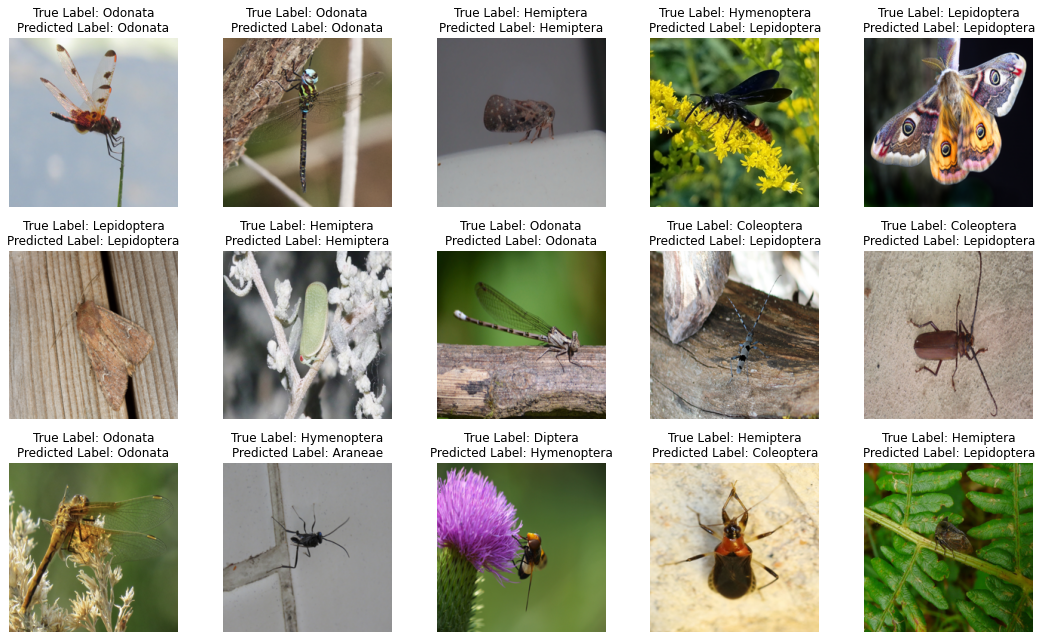

In [17]:
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv3.h5")

# Set the path to the test set
test_dir = "C:\\kaggle\input\ArTaxOr"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\kaggle\input\ArTaxOr"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()


# Testing on Mobile Corpus

            labels  encoded_labels
0          Araneae               0
4776    Coleoptera               1
5315       Diptera               2
5892     Hemiptera               3
6580   Hymenoptera               4
7251   Lepidoptera               5
10649      Odonata               6
Found 14530 images belonging to 7 classes.
228/228 [==============================] - 7786s 34s/step - loss: 0.5278 - accuracy: 0.8224 - recall_1: 0.7600 - precision_1: 0.8893 - auc_1: 0.9762
Found 14530 images belonging to 7 classes.
1/1 [==============================] - 0s 153ms/step


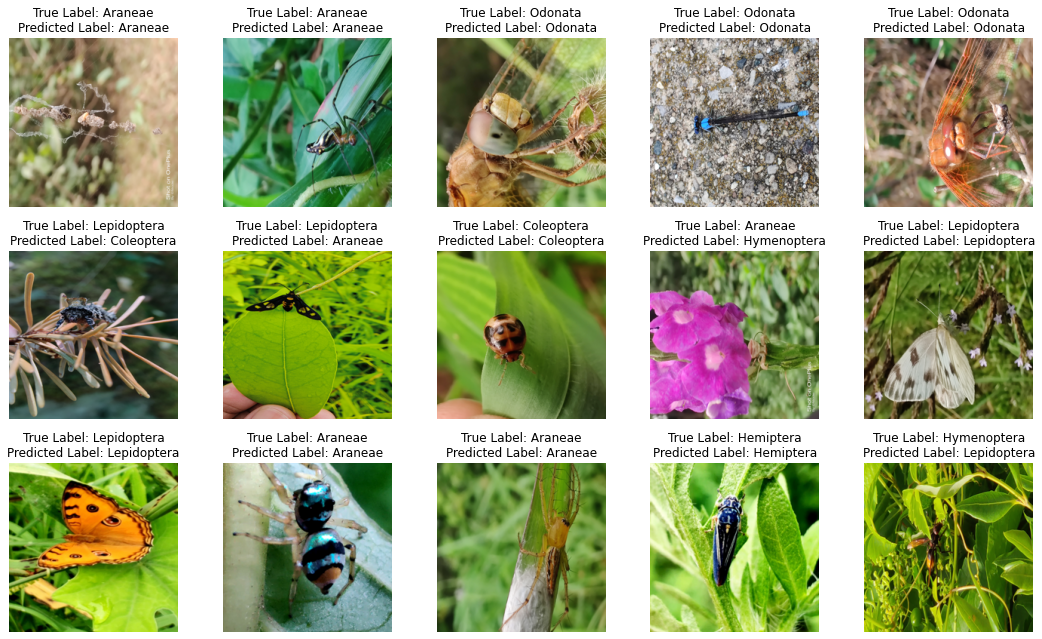

In [25]:
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv3.h5")

# Set the path to the test set
test_dir = "C:\\DL Testing Set"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Testing Set"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("Alexnet v3 Test Loss:", test_results[0])
print("Alexnet v3 Test Accuracy:", test_results[1])


# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()


# Testing on Small Mobile Corpus

In [18]:
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have train_gen and test_gen already defined as ImageDataGenerator instances
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
test_gen = ImageDataGenerator(rescale=(1./255.))

# Specify the path to the test set
test_dir = "C:\\DL Small Set"

# Evaluate the model on the test set
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

Found 118 images belonging to 7 classes.
2/2 [==============================] - 62s 29s/step - loss: 0.9381 - accuracy: 0.6610 - recall_1: 0.5932 - precision_1: 0.7527 - auc_1: 0.9279
Test Loss: 0.9380557537078857
Test Accuracy: 0.6610169410705566


          labels  encoded_labels
0        Araneae               0
15    Coleoptera               1
35       Diptera               2
50     Hemiptera               3
69   Hymenoptera               4
88   Lepidoptera               5
103      Odonata               6
Found 118 images belonging to 7 classes.
2/2 [==============================] - 65s 28s/step - loss: 0.9381 - accuracy: 0.6610 - recall_1: 0.5932 - precision_1: 0.7527 - auc_1: 0.9279
Found 118 images belonging to 7 classes.
1/1 [==============================] - 0s 398ms/step


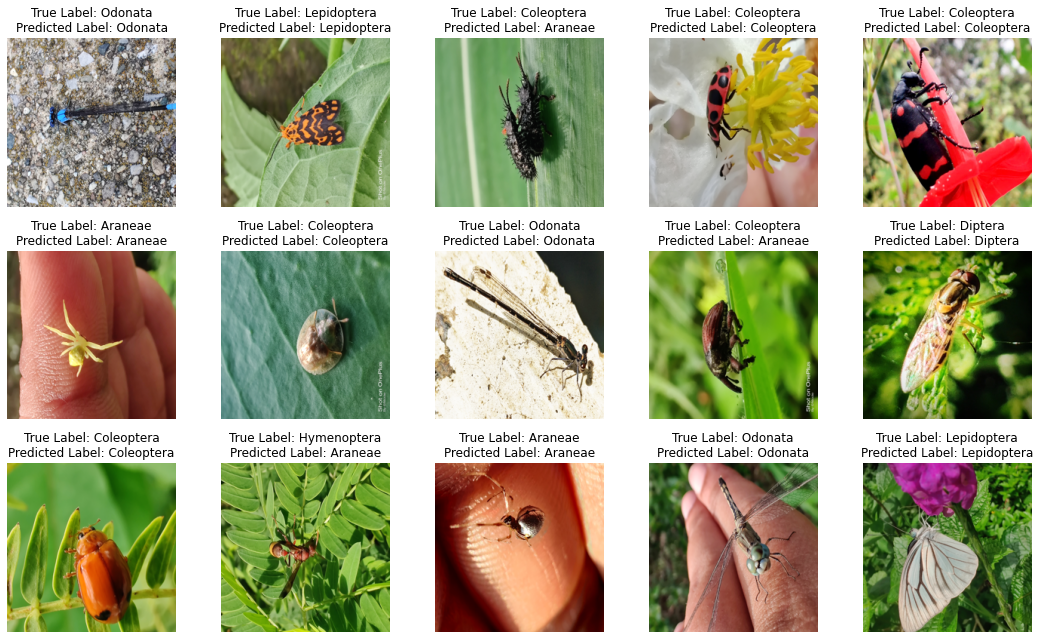

In [19]:
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv3.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Set"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Set"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()


# A mixture of images from both datasets - ArTaxOR and Mobile Corpus

In [20]:
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have train_gen and test_gen already defined as ImageDataGenerator instances
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
test_gen = ImageDataGenerator(rescale=(1./255.))

# Specify the path to the test set
test_dir = "C:\\DL Small Artax_Mobl Mix"

# Evaluate the model on the test set
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

Found 229 images belonging to 7 classes.
4/4 [==============================] - 80s 19s/step - loss: 1.0668 - accuracy: 0.6288 - recall_1: 0.5546 - precision_1: 0.7017 - auc_1: 0.9100
Test Loss: 1.0667507648468018
Test Accuracy: 0.6288209557533264


          labels  encoded_labels
0        Araneae               0
31    Coleoptera               1
66       Diptera               2
96     Hemiptera               3
130  Hymenoptera               4
164  Lepidoptera               5
196      Odonata               6
Found 229 images belonging to 7 classes.
4/4 [==============================] - 82s 18s/step - loss: 1.0668 - accuracy: 0.6288 - recall_1: 0.5546 - precision_1: 0.7017 - auc_1: 0.9100
Found 229 images belonging to 7 classes.
1/1 [==============================] - 0s 161ms/step


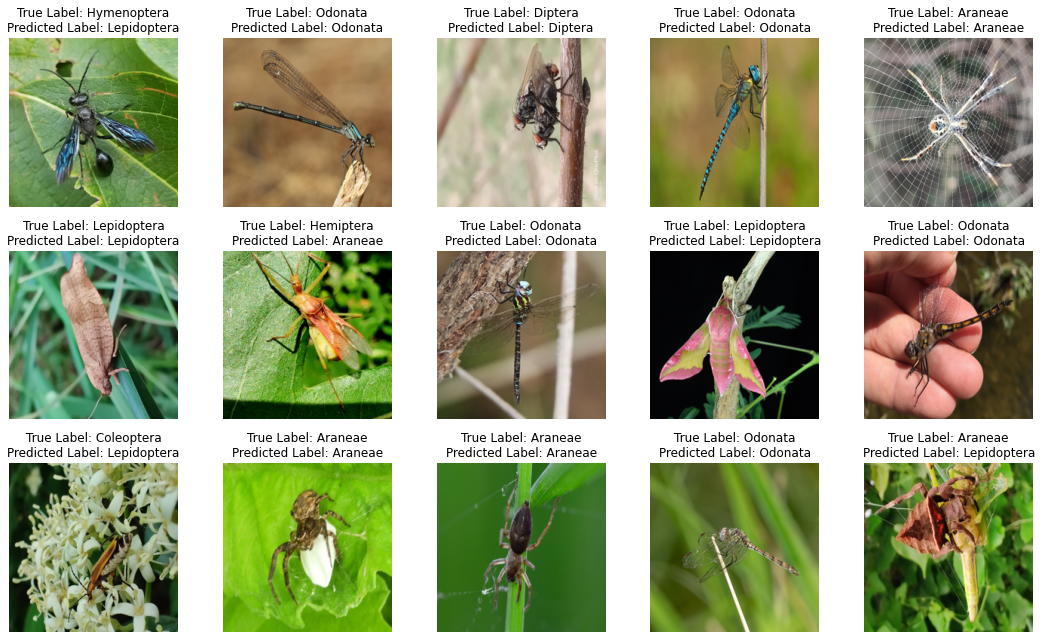

In [21]:
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv3.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()

# Display the evaluation results
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])


In [24]:
#alexnet_modelv3

loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

# Confusion Matrices

## ArTaxOr Mobile Corpus Mix

          labels  encoded_labels
0        Araneae               0
31    Coleoptera               1
66       Diptera               2
96     Hemiptera               3
130  Hymenoptera               4
164  Lepidoptera               5
196      Odonata               6
1/1 [==============================] - 0s 263ms/step


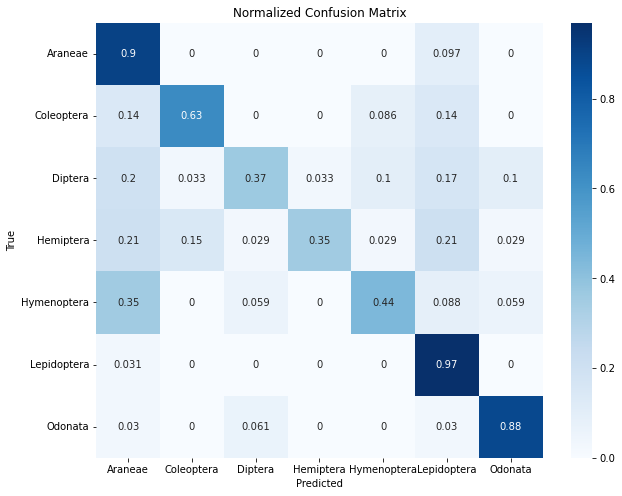

Classification Report:
              precision    recall  f1-score   support

     Araneae       0.47      0.90      0.62        31
  Coleoptera       0.79      0.63      0.70        35
     Diptera       0.69      0.37      0.48        30
   Hemiptera       0.92      0.35      0.51        34
 Hymenoptera       0.68      0.44      0.54        34
 Lepidoptera       0.56      0.97      0.71        32
     Odonata       0.83      0.88      0.85        33

    accuracy                           0.65       229
   macro avg       0.71      0.65      0.63       229
weighted avg       0.71      0.65      0.63       229



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv3.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))



## Small Mobile Corpus

          labels  encoded_labels
0        Araneae               0
15    Coleoptera               1
35       Diptera               2
50     Hemiptera               3
69   Hymenoptera               4
88   Lepidoptera               5
103      Odonata               6
1/1 [==============================] - 0s 85ms/step


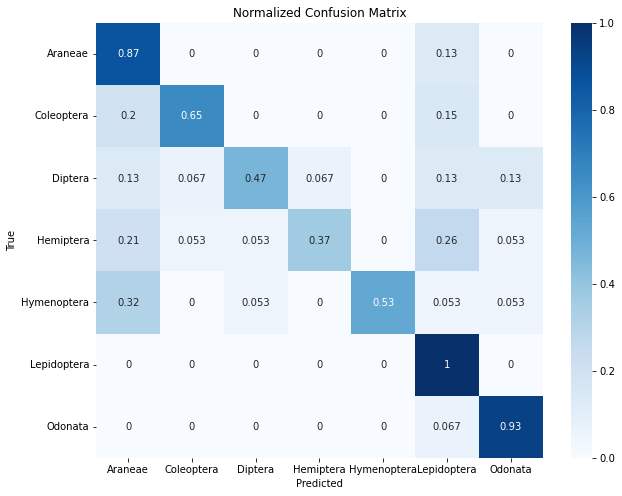

Classification Report:
              precision    recall  f1-score   support

     Araneae       0.45      0.87      0.59        15
  Coleoptera       0.87      0.65      0.74        20
     Diptera       0.78      0.47      0.58        15
   Hemiptera       0.88      0.37      0.52        19
 Hymenoptera       1.00      0.53      0.69        19
 Lepidoptera       0.52      1.00      0.68        15
     Odonata       0.78      0.93      0.85        15

    accuracy                           0.67       118
   macro avg       0.75      0.69      0.67       118
weighted avg       0.77      0.67      0.66       118



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv3.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Set"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Set"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))



## ArTaxOR 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv3.h5")

# Set the path to the test set
test_dir = "C:\\kaggle\input\ArTaxOr"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\kaggle\input\ArTaxOr"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))



            labels  encoded_labels
0          Araneae               0
2418    Coleoptera               1
4528       Diptera               2
6558     Hemiptera               3
8945   Hymenoptera               4
10993  Lepidoptera               5
13099      Odonata               6
1/1 [==============================] - 11s 11s/step


# Mobile Corpus

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/alexnet_modelv3.h5")

# Set the path to the test set
test_dir = "C:\\DL Testing Set"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Testing Set"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 128

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))



In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications.inception_v3 import InceptionV3

def get_alexnet_model(num_classes):
    model = Sequential([
        # Base InceptionV3 model
        InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
        
        # Global average pooling layer
        layers.GlobalAveragePooling2D(),
        
        # Dense layer with 1024 units and ReLU activation
        layers.Dense(1024, activation='relu'),
        
        # Dropout layer with a rate of 0.5
        layers.Dropout(0.5),
        
        # Output layer with softmax activation
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

num_classes = 7  # Replace with the actual number of classes
inception_model = get_alexnet_model(num_classes)
inception_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 23,908,135
Trainable params: 23,873,703
Non-trainable params: 34,432
_______________________________________